In [ ]:
pip install diffrax equinox optax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.7/141.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 7.2 MB/s eta 0:00:00


In [ ]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

In [ ]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

In [ ]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        print(f"y0: {y0}")
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [ ]:
def _get_data(ts, *, key):
    y0 = jr.uniform(key, (2,), minval=-0.6, maxval=1)

    def f(t, y, args):
        x = y / (1 + y)
        return jnp.stack([x[1], -x[0]], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.1
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 10, 100)
    key = jr.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [ ]:
key = jr.PRNGKey(42)
ts, ys = get_data(1000, key=key)
print(ys.shape)

(1000, 100, 2)


In [ ]:
keys = jr.split(key, 1000)
y0 = jr.uniform(keys[1], (2,), minval=-0.6, maxval=1)
y0

Array([0.5184099, 0.9704113], dtype=float32)

In [ ]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [ ]:
ys = jnp.ones((32, 10, 2))

In [ ]:
ys[:, 0]  # 32, 2
ys[:, 0, :].shape

(32, 2)

In [ ]:
def main(
    dataset_size=256,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(500, 500),
    length_strategy=(0.1, 1),
    width_size=64,
    depth=2,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jr.PRNGKey(seed)
    data_key, model_key, loader_key = jr.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)


    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        print(f"yi: {yi}")
        # yi es de tamaño: [32,10,2]
        # yi[:, 0] es en verdad la condición inicial de tamaño [32, 2]
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0, :])
        return jnp.mean((yi - y_pred) ** 2)

    # Es la clausura de la optimización
    # (i.e. lo que ocurre en cada paso)
    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    # Entrenar NeuralODEs es pesado. Es difícil.

    # lr_strategy: (3e-3, 3e-3)
    # steps_strategy: (500, 500)
    # length_strategy: (0.1, 1)

    # Este for loop es en verdad dos fases de entrenamiento:
    # En la primera fase, se entrena por 500 pasos en el 10% del conjunto de datos
    # En la segunda fase, se entrena por 500 pasos en todos los datos.
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:
        plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
        plt.plot(ts, ys[0, :, 1], c="dodgerblue")
        model_y = model(ts, ys[0, 0])
        plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
        plt.plot(ts, model_y[:, 1], c="crimson")
        plt.legend()
        plt.tight_layout()
        plt.savefig("neural_ode.png")
        plt.show()

    return ts, ys, model

yi: Traced<ShapedArray(float32[32,10,2])>with<DynamicJaxprTrace(level=1/0)>
y0: Traced<ShapedArray(float32[2])>with<BatchTrace(level=4/0)> with
  val = Traced<ShapedArray(float32[32,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
Step: 0, Loss: 0.16657482087612152, Computation time: 7.41588568687439
Step: 100, Loss: 0.011155783198773861, Computation time: 0.009827613830566406
Step: 200, Loss: 0.00648130476474762, Computation time: 0.009515047073364258
Step: 300, Loss: 0.001382116344757378, Computation time: 0.01175379753112793
Step: 400, Loss: 0.0010733160888776183, Computation time: 0.011570453643798828
Step: 499, Loss: 0.000799159228336066, Computation time: 0.017423629760742188
yi: Traced<ShapedArray(float32[32,100,2])>with<DynamicJaxprTrace(level=1/0)>
y0: Traced<ShapedArray(float32[2])>with<BatchTrace(level=4/0)> with
  val = Traced<ShapedArray(float32[32,2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
Step: 0, Loss: 0.0282188281416893, Computation time: 6.8619472980

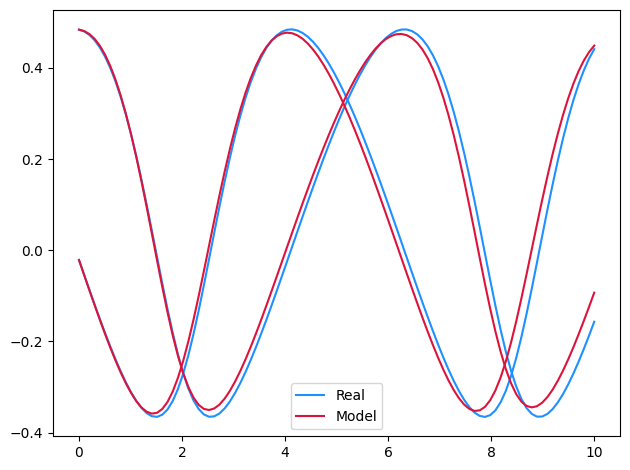

In [ ]:
ts, ys, model = main()